In [1]:
%%capture
!pip install higra

# Computing hierarchies on a region adjacency graph (RAG)

This notebook demonstrates how to compute a watershed hierarchy on the region adjacency graph of an image and shows how it can speed up computation.

In [2]:
import numpy as np
import imageio
%matplotlib inline
import matplotlib.pyplot as plt
import higra as hg

try:
    from utils import * # imshow, locate_resource, get_sed_model_file
except: # we are probably running from the cloud, try to fetch utils functions from URL
    import urllib.request as request; exec(request.urlopen('https://github.com/higra/Higra-Notebooks/raw/master/utils.py').read(), globals())

Image size: (481, 321)


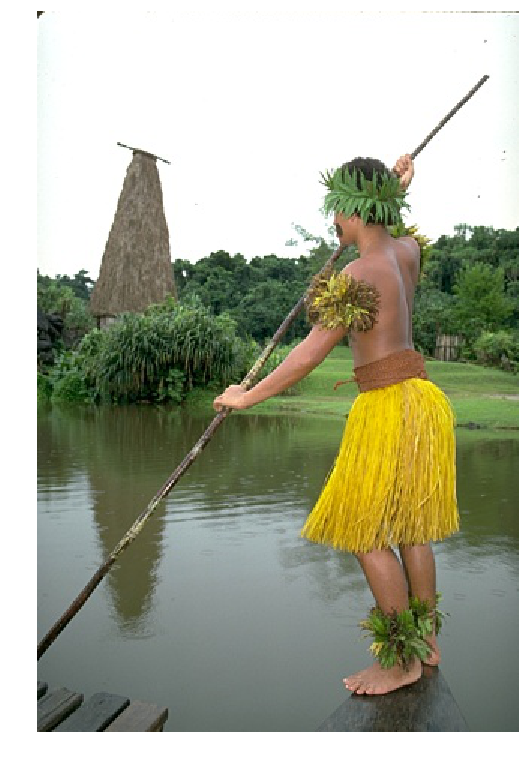

(<Figure size 481.5x721.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7faf3ad247f0>)

In [3]:
image = imageio.imread(locate_resource("101087.jpg"))
# switch to float to avoir numerical issue with uint8
image = image.astype(np.float64)/255 
# discard the color channel
size = image.shape[:2]
print("Image size:", size)
imshow(image)

We read a precomputed gradient

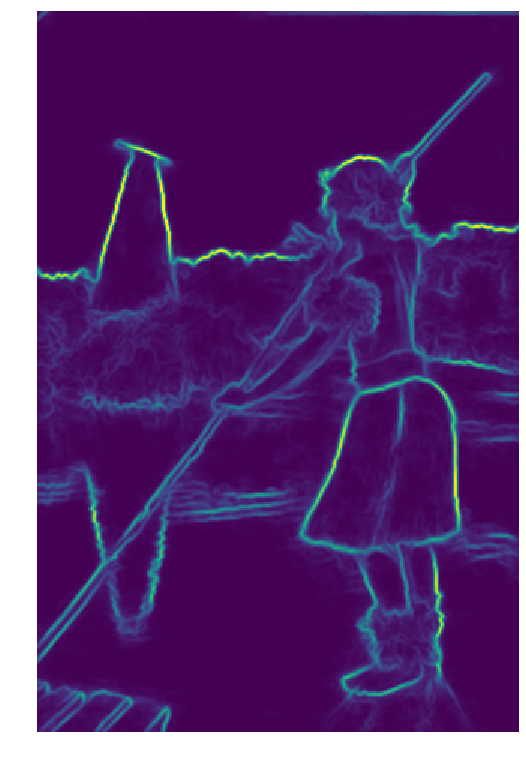

(<Figure size 481.5x721.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7faf3ac4f4e0>)

In [4]:
sed_gradient = imageio.imread(locate_resource("101087_SED.png"))
sed_gradient = sed_gradient.astype(np.float64)/255
imshow(sed_gradient)

We compute edge weights from the gradient and display the result in the Khalimsky grid

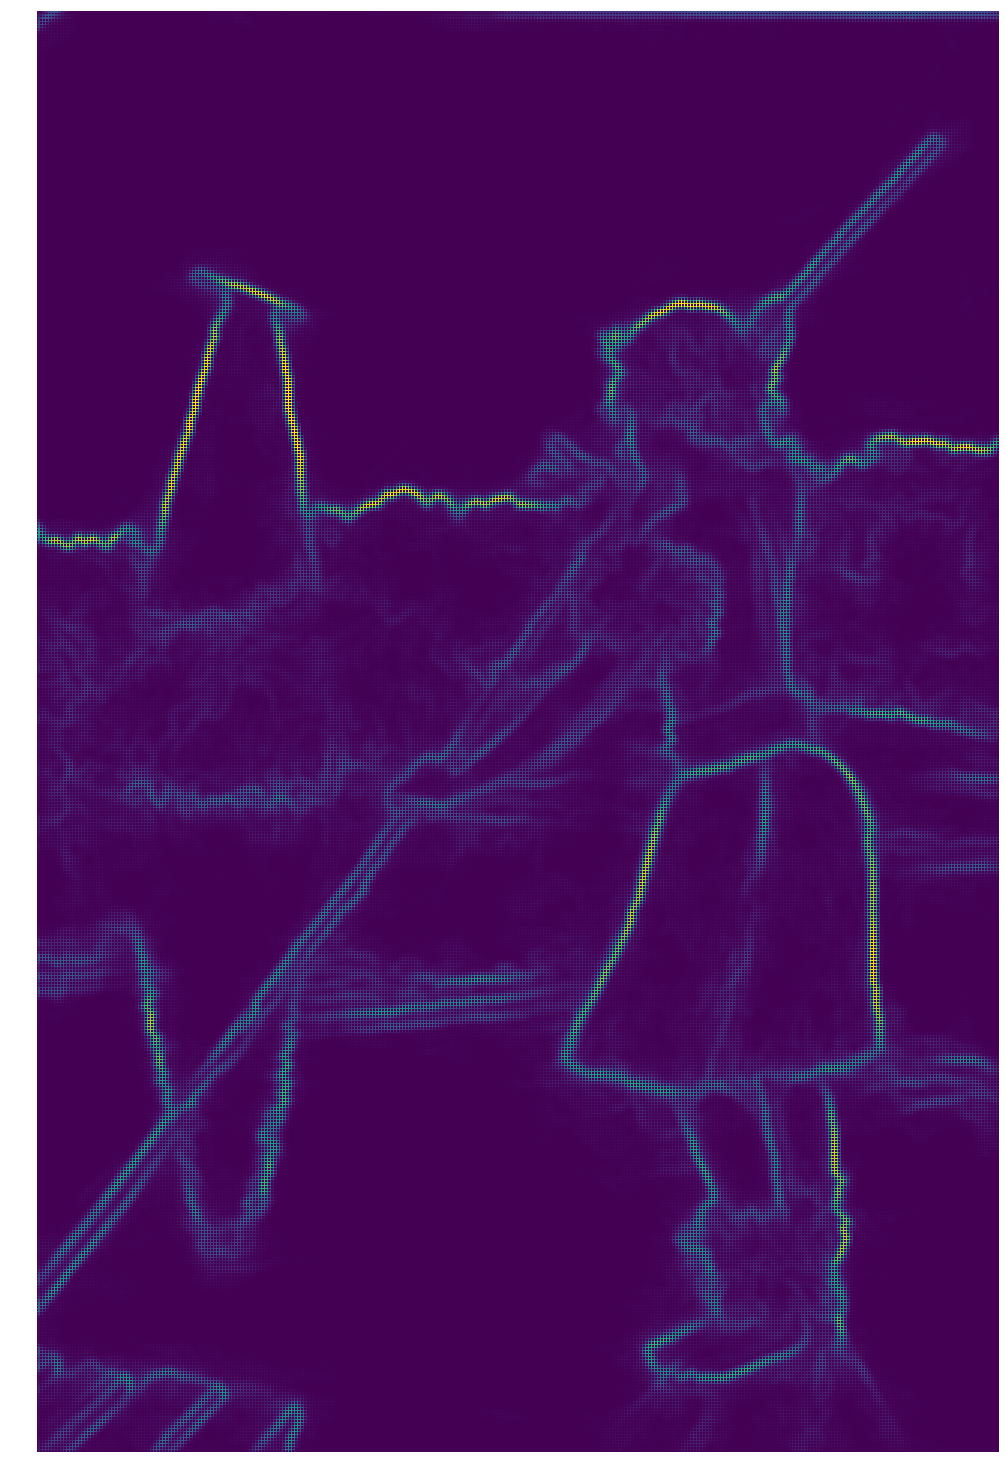

(<Figure size 961.5x1441.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7faf3ac0d390>)

In [5]:
graph = hg.get_4_adjacency_graph(size)
edge_weights = hg.weight_graph(graph, sed_gradient, hg.WeightFunction.mean)
sm = hg.graph_4_adjacency_2_khalimsky(graph, edge_weights)
imshow(sm)

## Watershed hierarchy by Area on Pixels

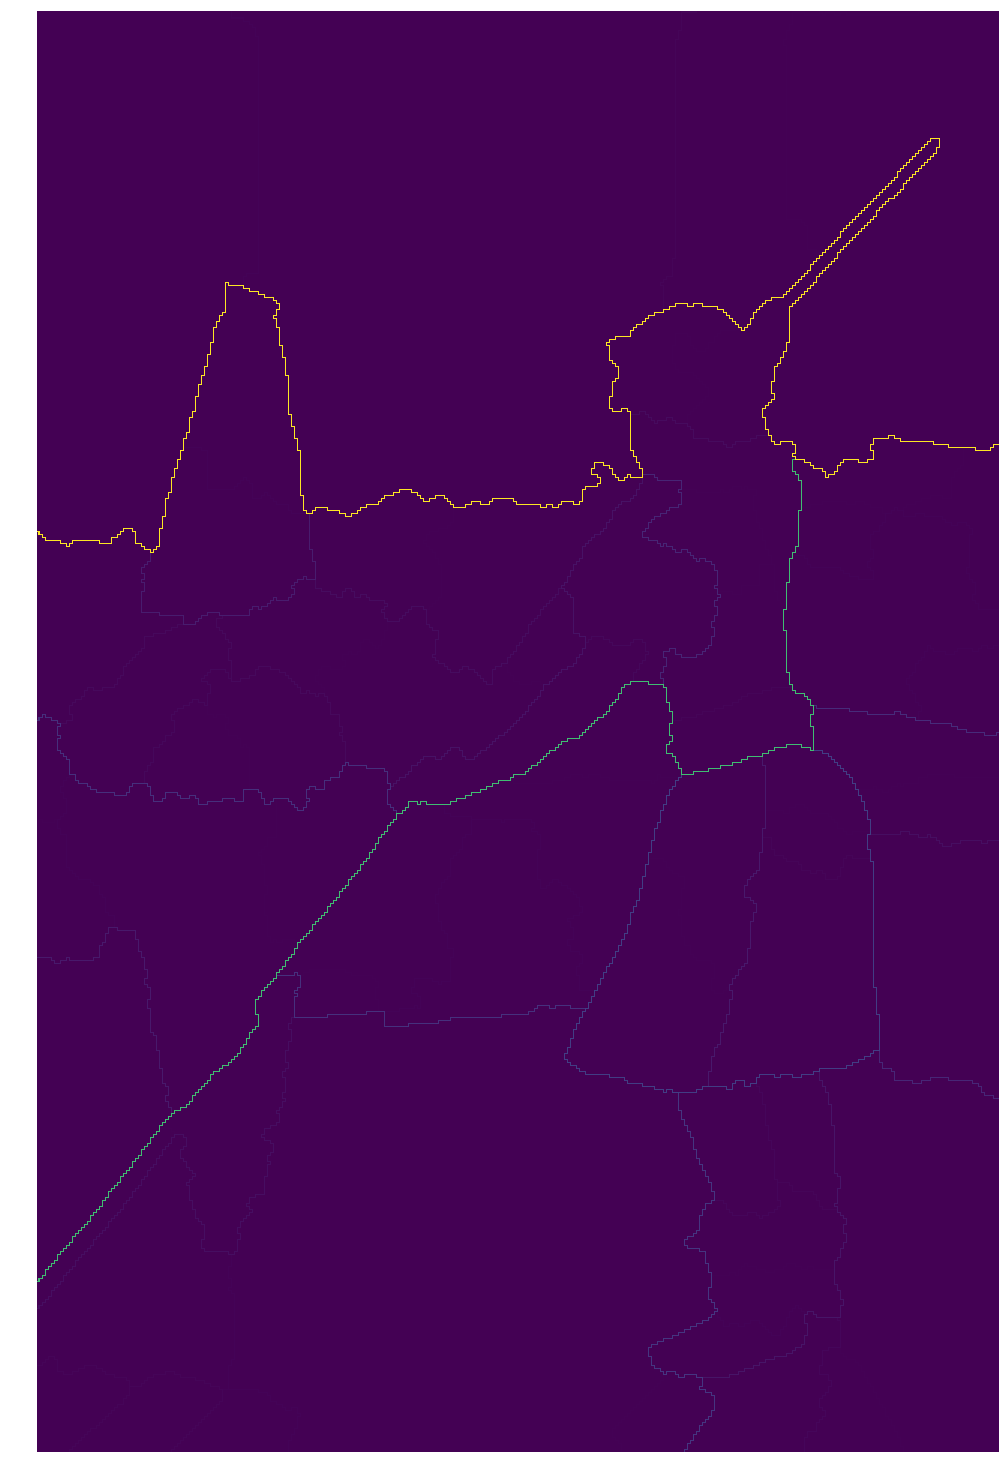

(<Figure size 961.5x1441.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7faf3abdd828>)

In [6]:
tree_ws_area, altitudes_ws_area = hg.watershed_hierarchy_by_area(graph, edge_weights)
sm = hg.saliency(tree_ws_area, altitudes_ws_area)
imshow(hg.graph_4_adjacency_2_khalimsky(graph, sm))

In [7]:
%%timeit 
tree_ws_area, altitudes_ws_area = hg.watershed_hierarchy_by_area(graph, edge_weights)
sm = hg.saliency(tree_ws_area, altitudes_ws_area)

181 ms ± 19.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Watershed hierarchy by Area on the region adjacency graph

In [8]:
def ws_area_rag(graph, edge_weights):
    # compute a first "superpixel" watershed segmentation
    vertex_labels = hg.labelisation_watershed(graph, edge_weights)
    # compute the associated graph
    rag = hg.make_region_adjacency_graph_from_labelisation(graph, vertex_labels)
    # the new rag edge weights are defined as the minimum along the rag boundaries 
    # (this choice is consistent for watershed hierarchies but could be different)
    rag_edge_weights = hg.rag_accumulate_on_edges(rag, hg.Accumulators.min, edge_weights)
    # watershed hierarchy on the smaller rag
    return hg.watershed_hierarchy_by_area(rag, rag_edge_weights)

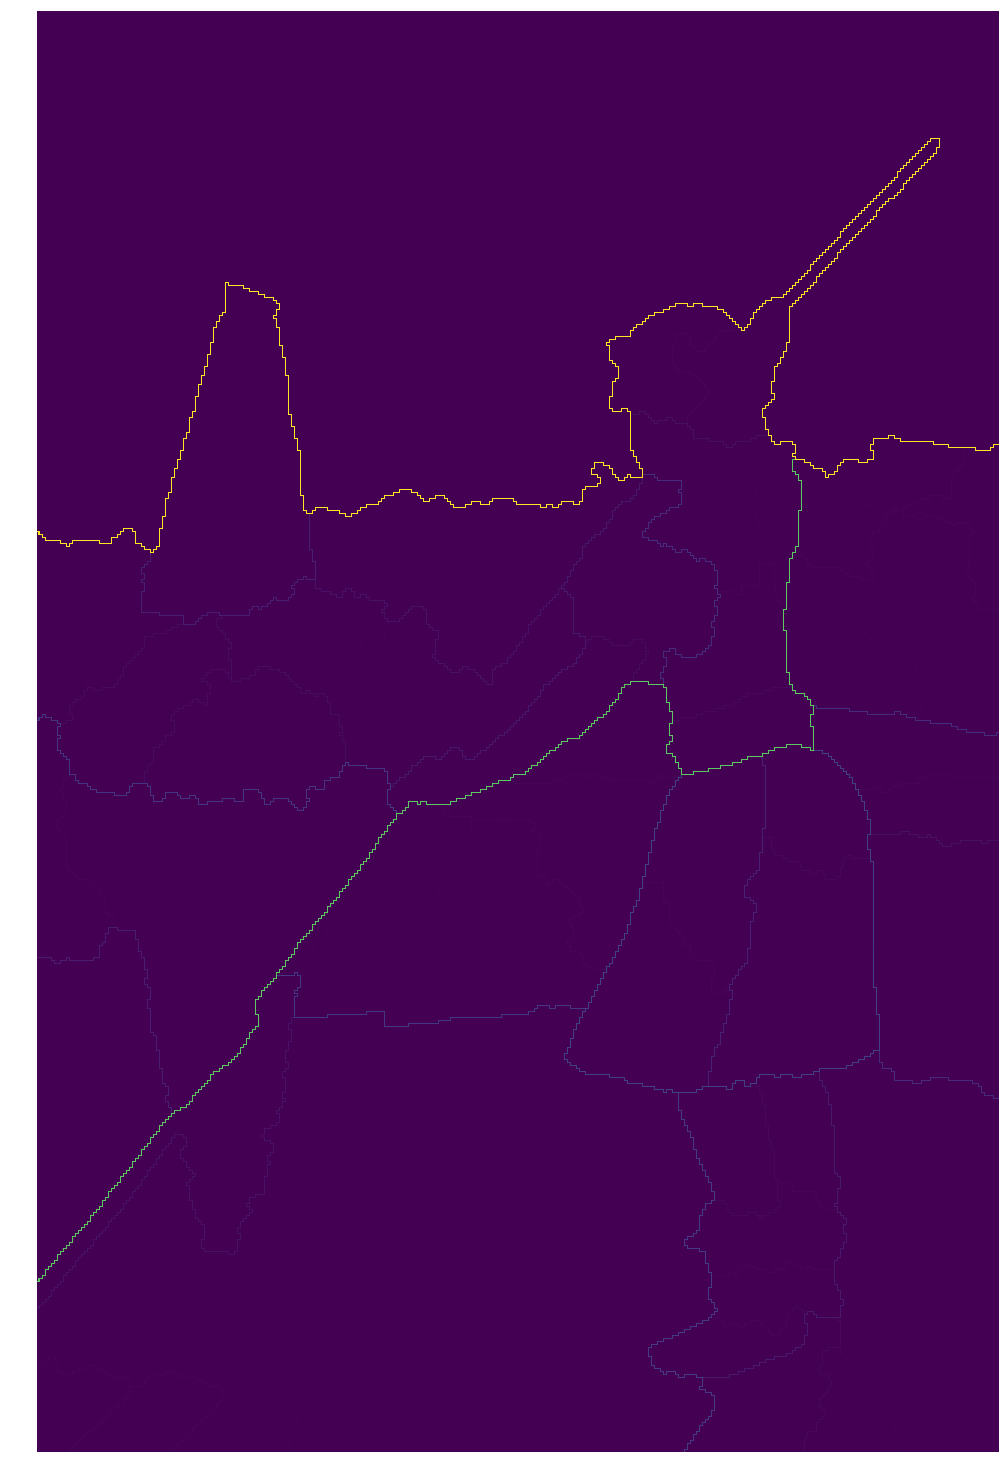

(<Figure size 961.5x1441.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7faf3ab550f0>)

In [9]:
tree_ws_area, altitudes_ws_area = ws_area_rag(graph, edge_weights)
sm = hg.saliency(tree_ws_area, altitudes_ws_area)
# notice that the saliency map is created for the original graph by default
imshow(hg.graph_4_adjacency_2_khalimsky(graph, sm))

In [10]:
%%timeit
tree_ws_area, altitudes_ws_area = ws_area_rag(graph, edge_weights)
sm = hg.saliency(tree_ws_area, altitudes_ws_area)

36.8 ms ± 267 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
